<a href="https://colab.research.google.com/github/kkmax-develop/FruitDiscrimination/blob/master/Transfer_Learning_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# GPUが割り当てられているかチェック
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### **ライブラリのインポート**

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

#画像認識関連ライブラリ
from tensorflow import keras
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization, Reshape,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

#ResNet50
from keras.applications.resnet50 import ResNet50

### **データの前処理**

ImageDataGeneratorクラスのインスタンスを作成。各引数の意味は公式ドキュメントを参照。

https://keras.io/ja/preprocessing/image/

In [21]:
# データ拡張の定義
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [22]:
# ImageDataGeneratorを使用してデータの読み込みと拡張
batch_size = 256
IMG_WIDTH = 32
IMG_HEIGHT = 32
CHANNELS = 3
CLASSES = 131
train_dir = "/content/drive/My Drive/Colab Notebooks/FruitDiscrimination/data/training"
TARGET = ["Apple Golden 1","Avocado","Banana","Blueberry","Cherry 1","Grape Pink","Kaki",
         "Lemon","Mango","Onion Red","Peach","Strawberry","Tomato 1"]

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            #classes=TARGET
        )

Found 67693 images belonging to 131 classes.


In [23]:
# validationの定義。データ拡張は行わず、正規化のみ実施。
validation_datagen = image.ImageDataGenerator(rescale=1.0 / 255)

In [24]:
# validationデータの読み込み
validation_dir = "/content/drive/My Drive/Colab Notebooks/FruitDiscrimination/data/test"
validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(IMG_WIDTH,IMG_HEIGHT),
            batch_size=batch_size,
            class_mode='categorical',
            #classes=TARGET
        )

Found 22689 images belonging to 131 classes.


### **モデル作成**

In [25]:
# ImageNetで学習したResNet50の読み込み
model_ResNet50 = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNELS))

# 全結合層の追加
model = Sequential()
model.add(model_ResNet50)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(CLASSES,activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 131)               67203     
Total params: 24,704,003
Trainable params: 24,650,883
Non-trainable params: 53,120
_________________________________________________________________


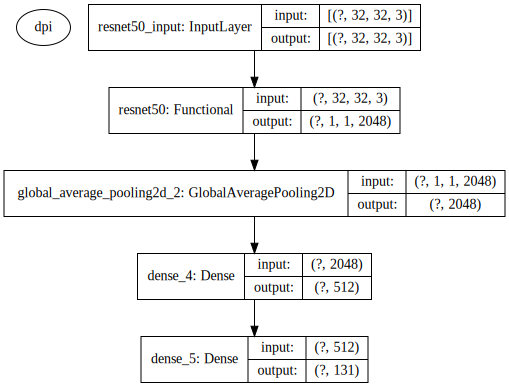

In [26]:
# 作成したモデルの可視化
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=None).create(prog='dot', format='svg'))

### **学習**

In [ ]:
# モデルの学習方法について指定
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.RMSprop(lr=1e-4, decay = 1e-6),
              metrics=['accuracy'])
 
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n  // validation_generator.batch_size



epochs = 10

# 学習 
result = model.fit_generator(train_generator,
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=STEP_SIZE_VALID)


Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.7067 - accuracy: 0.8456

In [ ]:
result.history.keys()

### **学習状況の可視化**

In [ ]:
plt.style.use('fivethirtyeight')
plt.title('Model Accuracy')
plt.plot(range(1, epochs+1), result.history['accuracy'], label="training")
plt.plot(range(1, epochs+1), result.history['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.style.use('fivethirtyeight')
plt.title('Model Loss')
plt.plot(range(1, epochs+1), result.history['loss'], label="training")
plt.plot(range(1, epochs+1), result.history['val_loss'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **モデルの保存**

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/FruitDiscrimination/model/ResNet50_Transfer.h5') 
